## Initial Models

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE



from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
from transformers import TFBertModel

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
# Reading the reviews
reviews_2000 = pd.read_csv("/content/drive/MyDrive/ISE540/Project/labelled_2000.csv")

In [ ]:
reviews_2000.head()

,Review,Review_Rating,Service,Food Quality,Ambiance/Atmosphere,Wait Time,Price,Menu Variety
0,What a shame. When stove and tap opened in Lan...,2,-2,2,-2,-2,1,1
1,"Service is much better, everyone enjoyed their...",3,3,2,-3,-3,-3,-3
2,The service here is generally very good. The ...,4,5,3,4,-4,-4,4
3,Best restaurant we've been to since moving her...,5,5,5,5,-5,-5,5
4,some of the best pizza in Boise. The employees...,5,5,5,5,-5,-5,-5


In [ ]:
# converting the negative values to 0
reviews_2000 = reviews_2000.applymap(lambda x: 0 if pd.to_numeric(x, errors='coerce') < 0 else x)
reviews_2000.head()

,Review,Review_Rating,Service,Food Quality,Ambiance/Atmosphere,Wait Time,Price,Menu Variety
0,What a shame. When stove and tap opened in Lan...,2,0,2,0,0,1,1
1,"Service is much better, everyone enjoyed their...",3,3,2,0,0,0,0
2,The service here is generally very good. The ...,4,5,3,4,0,0,4
3,Best restaurant we've been to since moving her...,5,5,5,5,0,0,5
4,some of the best pizza in Boise. The employees...,5,5,5,5,0,0,0


In [ ]:
# cleaning the reviews text

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def preprocess_text(text, stp_wrds):
  # Remove punctuation and convert to lowercase
  text = text.translate(str.maketrans('', '', string.punctuation)).lower()
  # Tokenize the text
  tokens = word_tokenize(text)
  if stp_wrds:
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
  return (' '.join(tokens))

In [ ]:
reviews_2000['Review_cleaned_without_stpwrds'] = reviews_2000['Review'].apply(preprocess_text, args=(True,))
reviews_2000['Review_cleaned_with_stpwrds'] = reviews_2000['Review'].apply(preprocess_text, args=(False,))

reviews_2000.head()

,Review,Review_Rating,Service,Food Quality,Ambiance/Atmosphere,Wait Time,Price,Menu Variety,Review_cleaned_without_stpwrds,Review_cleaned_with_stpwrds
0,What a shame. When stove and tap opened in Lan...,2,0,2,0,0,1,1,shame stove tap opened lansdale absolutely inc...,what a shame when stove and tap opened in lans...
1,"Service is much better, everyone enjoyed their...",3,3,2,0,0,0,0,service much better everyone enjoyed food mine...,service is much better everyone enjoyed their ...
2,The service here is generally very good. The ...,4,5,3,4,0,0,4,service generally good bartender really hustle...,the service here is generally very good the ba...
3,Best restaurant we've been to since moving her...,5,5,5,5,0,0,5,best restaurant weve since moving fall wow ord...,best restaurant weve been to since moving here...
4,some of the best pizza in Boise. The employees...,5,5,5,5,0,0,0,best pizza boise employee fun attentive live m...,some of the best pizza in boise the employees ...


## BERT Initial model

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
from transformers import TFBertModel

In [ ]:
reviews_2000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Review               2000 non-null   object
 1   Review_Rating        2000 non-null   int64 
 2   Service              2000 non-null   int64 
 3   Food Quality         2000 non-null   int64 
 4   Ambiance/Atmosphere  2000 non-null   int64 
 5   Wait Time            2000 non-null   int64 
 6   Price                2000 non-null   int64 
 7   Menu Variety         2000 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 125.1+ KB


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
review_1 = reviews_2000['Review'].iloc[0]
review_1

"What a shame. When stove and tap opened in Lansdale they were absolutely incredible. A shining star in a town that didn't really have a lot to offer. Oh how the mighty have fallen. The small menu doesn't really offer much that excites me. Especially for the price! I was going to get the salmon which was $26 but was told it came with no sides. So basically a chunk of salmon on a plate. Ok. Weird. No big deal. I'll just get something else. \n\nSo instead I ordered one of their salads and added salmon to it. The salad was $14 which isn't too bad for an entree sized salad and added the salmon for $10 which I feel is reasonable. However what I got was basically a side salad with salmon on the side. It tasted ok. Nothing special. But $14 for that salad is INSANE!!!!! I felt leaving like I got completely ripped off which really stinks because I used to absolutely love stove and tap. I hope whoever is in charge of the menu and pricing really steps it up because I know quite a few people that 

In [ ]:
token = tokenizer.encode_plus(
    review_1,
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)

In [ ]:
token

{'input_ids': <tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101,  1327,   170, 10499,   119,  1332, 18362,  1105, 12999,
         1533,  1107,  2001,  2316,  4319,  1152,  1127,  7284, 10965,
          119,   138, 10825,  2851,  1107,   170,  1411,  1115,  1238,
          112,   189,  1541,  1138,   170,  1974,  1106,  2906,   119,
         2048,  1293,  1103, 16370,  1138,  4984,   119,  1109,  1353,
        13171,  2144,   112,   189,  1541,  2906,  1277,  1115,  4252,
        14375,  1116,  1143,   119, 11008,  1111,  1103,  3945,   106,
          146,  1108,  1280,  1106,  1243,  1103, 17646,  1134,  1108,
          109,  1744,  1133,  1108,  1500,  1122,  1338,  1114,  1185,
         3091,   119,  1573, 11519,   170, 24384,  1104, 17646,  1113,
          170,  4885,   119, 23330,   119, 24209,   119,  1302,  1992,
         2239,   119,   146,   112,  1325,  1198,  1243,  1380,  1950,
          119,  1573,  1939,   146,  2802,  1141,  1104,  1147, 19359,
         1116, 

In [ ]:
X_input_ids = np.zeros((len(reviews_2000), 256))
X_attn_masks = np.zeros((len(reviews_2000), 256))

X_input_ids.shape, X_attn_masks.shape

((2000, 256), (2000, 256))

In [ ]:
def generate_training_data(df, ids, masks, tokenizer):
  for i, text in tqdm(enumerate(df['Review'])):
    token = tokenizer.encode_plus(
      text,
      max_length=256,
      truncation=True,
      padding='max_length',
      add_special_tokens=True,
      return_tensors='tf'
    )
    ids[i, :] = token.input_ids
    masks[i, :] = token.attention_mask

  return ids, masks

In [ ]:
X_input_ids, X_attn_masks = generate_training_data(reviews_2000, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [ ]:
X_input_ids

array([[  101.,  1327.,   170., ...,  1282.,  1106.,   102.],
       [  101.,  2516.,  1110., ...,     0.,     0.,     0.],
       [  101.,  1109.,  1555., ...,     0.,     0.,     0.],
       ...,
       [  101., 13045., 15981., ...,     0.,     0.,     0.],
       [  101.,   146.,  3683., ...,     0.,     0.,     0.],
       [  101., 13063.,  3452., ...,     0.,     0.,     0.]])

In [ ]:
labels = np.zeros((len(reviews_2000), 6))

In [ ]:
labels[np.arange(len(reviews_2000)), reviews_2000['Service'].values] = 1

In [ ]:
labels

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [ ]:
def map_function(input_ids, attn_masks, labels):
  return {
      'input_ids': input_ids,
      'attention_mask': attn_masks
  }, labels

In [ ]:
dataset = dataset.map(map_function)

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [ ]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True)

In [ ]:
p = 0.8
train_size = int((len(reviews_2000)//16)*p)
train_size

100

In [ ]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-cased')

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# model creation
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attention_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embeds = bert_model.bert(input_ids, attention_mask=attention_masks)[1]
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embeds)
output_layer = tf.keras.layers.Dense(6, activation='softmax', name='output_layer')(intermediate_layer)

model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                                       

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
100/100 [==============================] - 89s 891ms/step - loss: 1.1014 - accuracy: 0.5962 - val_loss: 0.8163 - val_accuracy: 0.6925
Epoch 2/5
100/100 [==============================] - 89s 891ms/step - loss: 0.8079 - accuracy: 0.7175 - val_loss: 0.6658 - val_accuracy: 0.7450
Epoch 3/5
100/100 [==============================] - 89s 890ms/step - loss: 0.6292 - accuracy: 0.7781 - val_loss: 0.5035 - val_accuracy: 0.8075
Epoch 4/5
100/100 [==============================] - 89s 891ms/step - loss: 0.5168 - accuracy: 0.8200 - val_loss: 0.2937 - val_accuracy: 0.9150
Epoch 5/5
100/100 [==============================] - 89s 889ms/step - loss: 0.4203 - accuracy: 0.8619 - val_loss: 0.3643 - val_accuracy: 0.8725


## BERT Final Model
## Handling all the categories

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
from transformers import TFBertModel

from sklearn.model_selection import train_test_split


## Reading the data

In [2]:
# Reading the reviews
reviews = pd.read_csv("/content/drive/MyDrive/ISE540/Project/labelled_with_zeros.csv")
reviews = reviews.drop(columns='Unnamed: 0')
reviews.head()

,Review,Review_Rating,Service,Food Quality,Ambiance/Atmosphere,Wait Time,Price,Menu Variety
0,The New Mexican a style cuisine here is damn g...,5.0,4.0,5.0,0.0,0.0,0.0,4.0
1,The Eastern European food is great but do not ...,5.0,0.0,5.0,0.0,5.0,0.0,5.0
2,Great service and great scene. Two levels with...,5.0,5.0,0.0,5.0,5.0,0.0,0.0
3,Had dinner here with my co-workers and this pl...,5.0,5.0,5.0,5.0,0.0,0.0,5.0
4,We have dined at Scoogi's many times and have ...,4.0,3.0,5.0,0.0,0.0,0.0,5.0


In [3]:
reviews.shape

(5000, 8)

## Splitting the data into train and test sets

In [4]:
X = reviews['Review']
y = reviews[["Review_Rating","Service",	"Food Quality",	"Ambiance/Atmosphere",	"Wait Time",	"Price",	"Menu Variety"]]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4000,), (4000, 7), (1000,), (1000, 7))

In [6]:
X_input_ids = np.zeros((len(X_train), 256))
X_attn_masks = np.zeros((len(X_train), 256))

X_input_ids.shape, X_attn_masks.shape

((4000, 256), (4000, 256))

In [7]:
def generate_training_data(data, ids, masks, tokenizer):
  for i, text in tqdm(enumerate(data)):
    token = tokenizer.encode_plus(
      text,
      max_length=256,
      truncation=True,
      padding='max_length',
      add_special_tokens=True,
      return_tensors='tf'
    )
    ids[i, :] = token.input_ids
    masks[i, :] = token.attention_mask

  return ids, masks

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
X_input_ids, X_attn_masks = generate_training_data(X_train, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [10]:
X_input_ids

array([[  101.,  1284.,  1125., ...,     0.,     0.,     0.],
       [  101.,  2066.,  1125., ...,     0.,     0.,     0.],
       [  101.,  1327.,   170., ...,     0.,     0.,     0.],
       ...,
       [  101., 16035.,  2094., ...,     0.,     0.,     0.],
       [  101.,  1109.,  2094., ...,     0.,     0.,     0.],
       [  101., 16035., 15688., ...,     0.,     0.,     0.]])

In [11]:
X_attn_masks

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [12]:
service_labels = y_train['Service'].to_numpy()
service_labels = tf.keras.utils.to_categorical(service_labels, num_classes=6 )

food_qlt_labels = y_train['Food Quality'].to_numpy()
food_qlt_labels = tf.keras.utils.to_categorical(food_qlt_labels, num_classes=6)

atmos_labels = y_train['Ambiance/Atmosphere'].to_numpy()
atmos_labels = tf.keras.utils.to_categorical(atmos_labels, num_classes=6 )

wait_labels = y_train['Wait Time'].to_numpy()
wait_labels = tf.keras.utils.to_categorical(wait_labels, num_classes=6 )

price_labels = y_train['Price'].to_numpy()
price_labels = tf.keras.utils.to_categorical(price_labels, num_classes=6 )

menu_labels = y_train['Menu Variety'].to_numpy()
menu_labels = tf.keras.utils.to_categorical(menu_labels, num_classes=6 )

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, service_labels, food_qlt_labels, atmos_labels, wait_labels, price_labels, menu_labels))

In [14]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(6,), dtype=tf.float32, name=None), TensorSpec(shape=(6,), dtype=tf.float32, name=None), TensorSpec(shape=(6,), dtype=tf.float32, name=None), TensorSpec(shape=(6,), dtype=tf.float32, name=None), TensorSpec(shape=(6,), dtype=tf.float32, name=None), TensorSpec(shape=(6,), dtype=tf.float32, name=None))>

In [15]:
def map_function(input_ids, attn_masks, service_labels, food_qlt_labels, atmos_labels, wait_labels, price_labels, menu_labels):
  return {
      'input_ids': input_ids,
      'attention_mask': attn_masks
  }, {
      'service_output': service_labels,
      'food_qlt_output': food_qlt_labels,
      'atmos_output': atmos_labels,
      'wait_output': wait_labels,
      'price_output': price_labels,
      'menu_output': menu_labels
  }

In [16]:
dataset = dataset.map(map_function)

In [17]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, {'service_output': TensorSpec(shape=(6,), dtype=tf.float32, name=None), 'food_qlt_output': TensorSpec(shape=(6,), dtype=tf.float32, name=None), 'atmos_output': TensorSpec(shape=(6,), dtype=tf.float32, name=None), 'wait_output': TensorSpec(shape=(6,), dtype=tf.float32, name=None), 'price_output': TensorSpec(shape=(6,), dtype=tf.float32, name=None), 'menu_output': TensorSpec(shape=(6,), dtype=tf.float32, name=None)})>

In [18]:
dataset = dataset.shuffle(10000, seed=42, reshuffle_each_iteration=False).batch(16, drop_remainder=True)

## Splitting the train set into train and validation sets

In [19]:
p = 0.8
train_size = int((len(X_train)//16)*p)
train_size

200

In [20]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [21]:
train_cardinality = tf.data.experimental.cardinality(train_dataset).numpy()
val_cardinality = tf.data.experimental.cardinality(val_dataset).numpy()

print(f"Number of samples in the train dataset: {train_cardinality * 16}")
print(f"Number of samples in the validation dataset: {val_cardinality * 16}")

Number of samples in the train dataset: 3200
Number of samples in the validation dataset: 800


In [22]:
service = []
food = []
atmos = []
wait = []
price = []
menu = []


for batch in val_dataset:
    input_data, labels = batch
    service.append(labels['service_output'])
    food.append(labels['food_qlt_output'])
    atmos.append(labels['atmos_output'])
    wait.append(labels['wait_output'])
    price.append(labels['price_output'])
    menu.append(labels['menu_output'])

In [23]:
def label_transformer(tf_labels_list):
  labels = np.array(tf_labels_list)
  labels = labels.reshape((800, 6))
  labels = np.argmax(labels, axis=1)
  return labels

In [24]:
test_service = label_transformer(service)
test_food = label_transformer(food)
test_atmos = label_transformer(atmos)
test_wait = label_transformer(wait)
test_price = label_transformer(price)
test_menu = label_transformer(menu)
y_val = np.vstack((test_service, test_food, test_atmos, test_wait, test_price, test_menu)).T

In [25]:
y_val

array([[2, 0, 1, 0, 1, 0],
       [5, 0, 5, 0, 0, 0],
       [0, 3, 0, 0, 0, 3],
       ...,
       [4, 5, 5, 4, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [5, 5, 5, 0, 0, 0]])

In [26]:
y_val.shape

(800, 6)

## Preparing the test dataset

In [27]:
X_input_ids = np.zeros((len(X_test), 256))
X_attn_masks = np.zeros((len(X_test), 256))

X_input_ids.shape, X_attn_masks.shape

((1000, 256), (1000, 256))

In [28]:
X_input_ids, X_attn_masks = generate_training_data(X_test, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [29]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks))

In [30]:
def map_function(input_ids, attn_masks):
  return {
      'input_ids': input_ids,
      'attention_mask': attn_masks
  }

In [31]:
test_dataset = test_dataset.map(map_function)
test_dataset = test_dataset.batch(100, drop_remainder=True)

## Defining BERT model

In [45]:
bert_model = TFBertModel.from_pretrained('bert-base-cased')

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [46]:
# model creation
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attention_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embeds = bert_model.bert(input_ids, attention_mask=attention_masks)[1]
intermediate_layer_1 = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer_1')(bert_embeds)
#intermediate_layer_2 = tf.keras.layers.Dense(256, activation='relu', name='intermediate_layer_2')(intermediate_layer_1)
service_output = tf.keras.layers.Dense(6, activation='softmax', name='service_output')(intermediate_layer_1)
food_qlt_output = tf.keras.layers.Dense(6, activation='softmax', name='food_qlt_output')(intermediate_layer_1)
atmos_output = tf.keras.layers.Dense(6, activation='softmax', name='atmos_output')(intermediate_layer_1)
wait_output = tf.keras.layers.Dense(6, activation='softmax', name='wait_output')(intermediate_layer_1)
price_output = tf.keras.layers.Dense(6, activation='softmax', name='price_output')(intermediate_layer_1)
menu_output = tf.keras.layers.Dense(6, activation='softmax', name='menu_output')(intermediate_layer_1)

model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=[service_output, food_qlt_output, atmos_output, wait_output, price_output, menu_output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                                       

In [47]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5)
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
loss_func = tf.keras.losses.CategoricalCrossentropy()

In [48]:
model.compile(optimizer=optim,
              loss={'service_output': loss_func, 'food_qlt_output': loss_func, 'atmos_output': loss_func, 'wait_output': loss_func, 'price_output': loss_func, 'menu_output': loss_func},
              metrics=['accuracy'])

In [49]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=8)

Epoch 1/8
200/200 [==============================] - 103s 315ms/step - loss: 7.4596 - service_output_loss: 1.5185 - food_qlt_output_loss: 1.4765 - atmos_output_loss: 1.2566 - wait_output_loss: 0.9880 - price_output_loss: 1.1494 - menu_output_loss: 1.0707 - service_output_accuracy: 0.3984 - food_qlt_output_accuracy: 0.4419 - atmos_output_accuracy: 0.5778 - wait_output_accuracy: 0.7347 - price_output_accuracy: 0.6344 - menu_output_accuracy: 0.6581 - val_loss: 6.2572 - val_service_output_loss: 1.2536 - val_food_qlt_output_loss: 1.2624 - val_atmos_output_loss: 1.0923 - val_wait_output_loss: 0.7919 - val_price_output_loss: 0.9775 - val_menu_output_loss: 0.8795 - val_service_output_accuracy: 0.5088 - val_food_qlt_output_accuracy: 0.5175 - val_atmos_output_accuracy: 0.6450 - val_wait_output_accuracy: 0.7925 - val_price_output_accuracy: 0.7138 - val_menu_output_accuracy: 0.7075
Epoch 2/8
200/200 [==============================] - 60s 300ms/step - loss: 5.8305 - service_output_loss: 1.1285 - fo

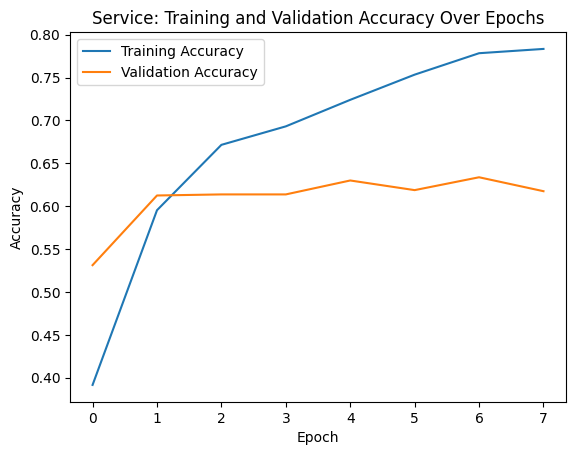

In [37]:
# Plot epoch vs accuracy
plt.plot(history.history['service_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_service_output_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Service: Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

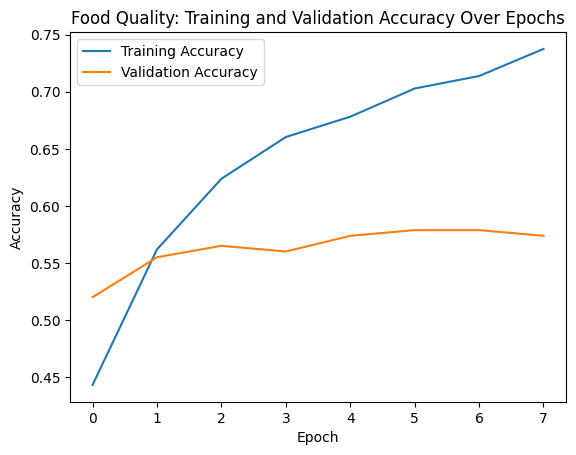

In [38]:
# Plot epoch vs accuracy
plt.plot(history.history['food_qlt_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_food_qlt_output_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Food Quality: Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

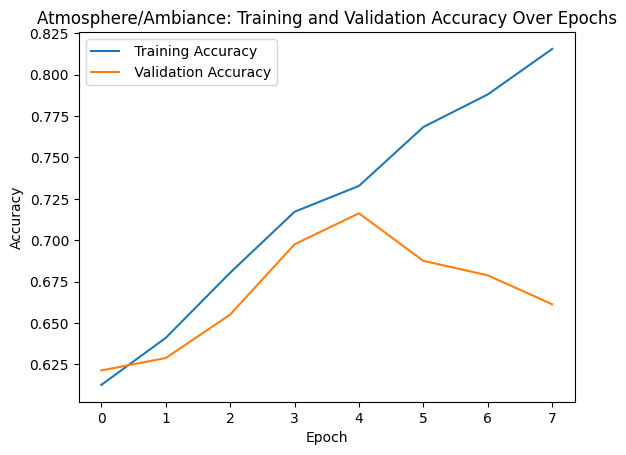

In [39]:
# Plot epoch vs accuracy
plt.plot(history.history['atmos_output_accuracy'], label=' Training Accuracy')
plt.plot(history.history['val_atmos_output_accuracy'], label=' Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Atmosphere/Ambiance: Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

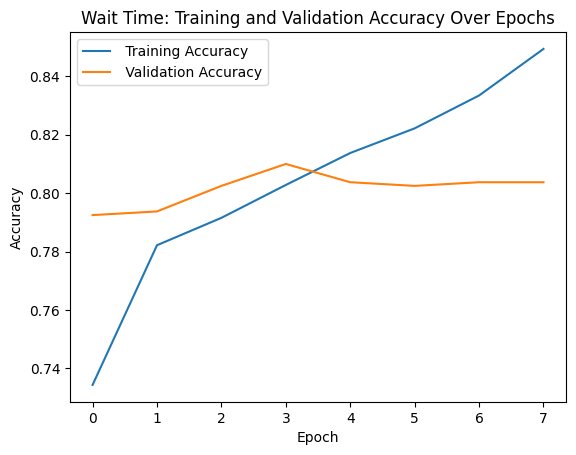

In [40]:
# Plot epoch vs accuracy
plt.plot(history.history['wait_output_accuracy'], label=' Training Accuracy')
plt.plot(history.history['val_wait_output_accuracy'], label=' Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Wait Time: Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

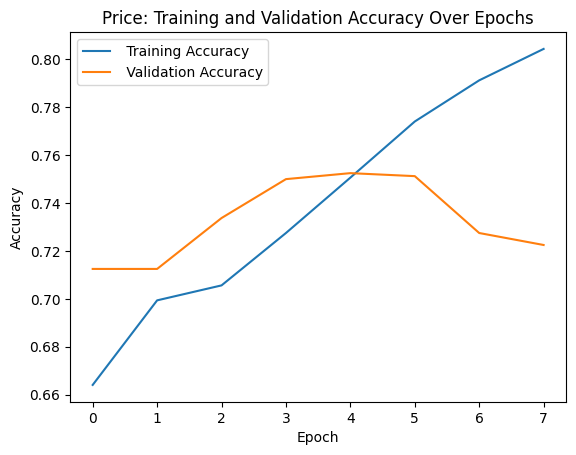

In [41]:
# Plot epoch vs accuracy
plt.plot(history.history['price_output_accuracy'], label=' Training Accuracy')
plt.plot(history.history['val_price_output_accuracy'], label=' Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Price: Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

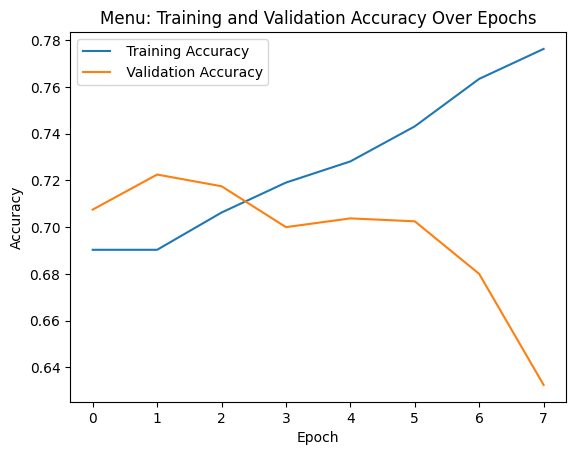

In [42]:
# Plot epoch vs accuracy
plt.plot(history.history['menu_output_accuracy'], label=' Training Accuracy')
plt.plot(history.history['val_menu_output_accuracy'], label=' Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Menu: Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

## Saving the model and model evaluation

In [51]:
model.save("/content/drive/MyDrive/ISE540/Project/bert_model")

In [32]:
model = tf.keras.models.load_model("/content/drive/MyDrive/ISE540/Project/bert_model")

In [48]:
preds = model.predict(val_dataset)

50/50 [==============================] - 9s 83ms/step


In [49]:
!nvidia-smi

Sun Nov 26 20:25:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    55W / 300W |   2718MiB / 16384MiB |     96%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
y_preds = np.array(preds)
y_preds.shape

(6, 800, 6)

In [45]:
y_preds = np.argmax(y_preds, axis=2)
y_preds = y_preds.T
y_preds.shape

(800, 6)

In [55]:
def acc(ground_truth, predictions):
  non_zero_positions = (ground_truth >= 0) & (predictions >= 0)
  correct_predictions = (ground_truth[non_zero_positions] == predictions[non_zero_positions])
  accuracy = correct_predictions.sum() / non_zero_positions.sum() if non_zero_positions.sum() > 0 else 0
  return accuracy

## This below function could be used in future analysis and hence is commented

# def acc(actual, predicted):
#   matches = 0
#   count = 0
#   for i in range(len(actual)):
#     if actual[i] == 0:
#       continue
#     elif actual[i] == 1 and (predicted[i] == 1 or predicted[i] == 2):
#       matches += 1
#     elif actual[i] == 2 and (predicted[i] == 1 or predicted[i] == 2):
#       matches += 1
#     elif actual[i] == 3 and (predicted[i] == 2 or predicted[i] == 3 or predicted[i] == 4):
#       matches += 1
#     elif actual[i] == 4 and (predicted[i] == 4 or predicted[i] == 5):
#       matches += 1
#     elif actual[i] == 5 and (predicted[i] == 4 or predicted[i] == 5):
#       matches += 1
#     count+=1

#   return matches / count

def multiclass_accuracy(y_true, y_pred):
  labels = ['Service', 'Food Quality', 'Atmosphere/Ambiance', 'Wait Time', 'Price', 'Menu Variety']

  sum_acc = 0

  for i in range(len(labels)):
    temp_acc = acc(y_true[:,i], y_pred[:,i])
    sum_acc += temp_acc
    print(f"{labels[i]} Accuracy: {temp_acc*100:.3f}%")

  mean_acc = sum_acc / 6

  print(f"Average accuracy: {mean_acc*100:.3f}%")


In [47]:
# accuracy with 0s included (accuracy function which our team used)
multiclass_accuracy(y_val, y_preds)

Service Accuracy: 61.750%
Food Quality Accuracy: 57.375%
Atmosphere/Ambiance Accuracy: 66.125%
Wait Time Accuracy: 80.375%
Price Accuracy: 72.250%
Menu Variety Accuracy: 63.250%
Average accuracy: 66.854%


In [48]:
# accuracy with 0s not included (accuracy function which is commented above that can be used for future work)
multiclass_accuracy(y_val, y_preds)

Service Accuracy: 75.769%
Food Quality Accuracy: 83.548%
Atmosphere/Ambiance Accuracy: 53.846%
Wait Time Accuracy: 39.759%
Price Accuracy: 46.087%
Menu Variety Accuracy: 42.308%
Average accuracy: 56.886%


## Getting BERT predictions on test dataset

In [50]:
test_preds = model.predict(test_dataset)

10/10 [==============================] - 7s 488ms/step


In [51]:
test_preds = np.argmax(test_preds, axis=2)
test_preds = test_preds.T
test_preds.shape

(1000, 6)

In [52]:
actual_y_test = y_test[["Service",	"Food Quality",	"Ambiance/Atmosphere",	"Wait Time",	"Price",	"Menu Variety"]]

In [53]:
actual_y_test = actual_y_test.to_numpy()

In [56]:
multiclass_accuracy(actual_y_test, test_preds)

Service Accuracy: 62.900%
Food Quality Accuracy: 56.900%
Atmosphere/Ambiance Accuracy: 69.100%
Wait Time Accuracy: 79.800%
Price Accuracy: 72.600%
Menu Variety Accuracy: 70.000%
Average accuracy: 68.550%


In [55]:
y_preds

array([[1, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 0],
       [4, 5, 0, 0, 0, 0],
       ...,
       [5, 5, 5, 0, 0, 5],
       [1, 1, 0, 0, 1, 0],
       [5, 5, 5, 0, 0, 0]])

In [56]:
bert_test_predictions = pd.DataFrame({'Reviews': X_test}).reset_index(drop=True)

In [57]:
predicted_columns = ['Service predicted', 'Food Quality predicted', 'Atmosphere/Ambiance predicted', 'Wait Time predicted', 'Price predicted', 'Menu Variety predicted']
temp_df2 = pd.DataFrame(test_preds, columns = predicted_columns)


In [61]:
y_test = y_test.reset_index(drop=True)

In [65]:
final_df = pd.concat([bert_test_predictions, y_test, temp_df2], axis=1)
final_df.to_csv("/content/drive/MyDrive/ISE540/Project/bert_test_predictions_on_labelled_data.csv")

In [64]:
final_df

,Reviews,Review_Rating,Service,Food Quality,Ambiance/Atmosphere,Wait Time,Price,Menu Variety,Service predicted,Food Quality predicted,Atmosphere/Ambiance predicted,Wait Time predicted,Price predicted,Menu Variety predicted
0,"Love the ""CHEERS"" everybody knows your name t...",3.0,2.0,3.0,3.0,0.0,0.0,5.0,3,2,0,0,0,3
1,We found this place while trying to eat at the...,5.0,5.0,5.0,0.0,4.0,0.0,5.0,0,5,0,3,0,5
2,"Not our first time at this long time, well kno...",5.0,5.0,5.0,5.0,0.0,0.0,0.0,5,5,5,0,0,0
3,Went in last night it was the first time we ha...,5.0,5.0,0.0,0.0,5.0,5.0,0.0,5,5,0,5,0,0
4,"In all fairness, this place is good for a cert...",2.0,0.0,2.0,2.0,0.0,0.0,3.0,0,2,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,This is a place off the beaten path but once y...,5.0,0.0,5.0,5.0,0.0,4.0,5.0,0,5,5,0,5,0
996,Great food and service. We dined upstairs w/c ...,4.0,4.0,4.0,4.0,0.0,0.0,0.0,5,5,5,0,5,0
997,this wouldn't be a fair review since it's only...,4.0,5.0,4.0,5.0,0.0,4.0,5.0,4,4,0,0,4,5
998,Food is a four but parking is a one\nSam's Gol...,3.0,5.0,4.0,0.0,0.0,0.0,3.0,5,5,0,0,0,5


In [59]:
final_df.head()

,Reviews,Review_Rating,Service,Food Quality,Ambiance/Atmosphere,Wait Time,Price,Menu Variety,Service predicted,Food Quality predicted,Atmosphere/Ambiance predicted,Wait Time predicted,Price predicted,Menu Variety predicted
0,"Love the ""CHEERS"" everybody knows your name t...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,0.0,0.0,0.0,3.0
1,We found this place while trying to eat at the...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5.0,0.0,3.0,0.0,5.0
2,"Not our first time at this long time, well kno...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,0.0,0.0,0.0
3,Went in last night it was the first time we ha...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,0.0,5.0,0.0,0.0
4,"In all fairness, this place is good for a cert...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,2.0,0.0,0.0,0.0


## Predictions on unlabeled dataset

In [8]:
unlabeled_dataset = pd.read_csv("/content/drive/MyDrive/ISE540/Project/unlabelled_dataset.csv")

In [9]:
unlabeled_dataset.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,word_count
0,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,"{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",YByDh56Hl11HoYdBm-uArA,9hhRs_n85m-jsKOXp3jt7Q,1.0,0.0,0.0,0.0,Went there at 4am and there was only one waitr...,2016-05-08 08:49:25,87
1,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,"{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",3vwdkRRoUe4PewzD8HvQbQ,-BX5x3Ys-2JzFba3LiWlHA,1.0,0.0,0.0,0.0,I had an immensely frustrating experience here...,2017-08-30 10:52:52,186
2,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,"{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",LWQJo1dFvAgJQF_dxN6JCA,G_eZLhf1Kw5WBpMlXHizNQ,4.0,0.0,0.0,0.0,The staff here was great. We had a bunch of pe...,2014-03-16 13:59:31,41
3,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,"{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",yQJXhZIF6_VMC5gY7gBDAw,iYpCMhEqsped1647fF_u-A,1.0,0.0,0.0,0.0,Food was awful! Hamburger was burnt and cold....,2018-08-12 15:32:47,39
4,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,"{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",Hrch9QsiJ0EUOKN__-DkEQ,Zh74qahMMcAON7PVR-_T8Q,1.0,0.0,0.0,0.0,I give this Dennys a one star because I found ...,2018-03-30 14:49:35,46


In [ ]:
X_input_ids = np.zeros((len(unlabeled_dataset), 256))
X_attn_masks = np.zeros((len(unlabeled_dataset), 256))

X_input_ids.shape, X_attn_masks.shape

((1024688, 256), (1024688, 256))

In [ ]:
unlabeled_dataset = unlabeled_dataset.rename(columns={'text': 'Review'})

In [ ]:
X_input_ids, X_attn_masks = generate_training_data(unlabeled_dataset, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [ ]:
np.savez('/content/drive/MyDrive/ISE540/Project/tokenized_arrays.npz', array1=X_input_ids, array2=X_attn_masks)

In [ ]:
load_data = np.load("/content/tokenized_arrays.npz")

In [ ]:
X_input_ids = load_data['array1']
X_attn_masks = load_data['array2']

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks))

In [ ]:
def map_function(input_ids, attn_masks, service_labels, food_qlt_labels, atmos_labels, wait_labels, price_labels, menu_labels):
  return {
      'input_ids': input_ids,
      'attention_mask': attn_masks
  }

In [ ]:
test_dataset = test_dataset.map(map_function)

In [ ]:
test_dataset = test_dataset.shuffle(10000, seed=42, reshuffle_each_iteration=False).batch(16, drop_remainder=True)

In [2]:
test_dataset = tf.data.Dataset.load("/content/drive/MyDrive/ISE540/Project/test_data")

In [3]:
model = tf.keras.models.load_model("/content/drive/MyDrive/ISE540/Project/bert_model")

In [4]:
preds = model.predict(test_dataset)

64043/64043 [==============================] - 5462s 85ms/step


In [65]:
!nvidia-smi

Sun Nov 26 20:43:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    55W / 300W |   4766MiB / 16384MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
y_preds = np.array(preds)
y_preds.shape

(6, 1024688, 6)

In [6]:
y_preds = np.argmax(y_preds, axis=2)
y_preds = y_preds.T
y_preds.shape

(1024688, 6)

In [7]:
y_preds

array([[2, 2, 0, 0, 0, 0],
       [2, 3, 0, 2, 0, 0],
       [0, 5, 0, 0, 5, 5],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0],
       [2, 2, 0, 0, 0, 0]])

In [10]:
unlabeled_dataset.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,word_count
0,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,"{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",YByDh56Hl11HoYdBm-uArA,9hhRs_n85m-jsKOXp3jt7Q,1.0,0.0,0.0,0.0,Went there at 4am and there was only one waitr...,2016-05-08 08:49:25,87
1,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,"{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",3vwdkRRoUe4PewzD8HvQbQ,-BX5x3Ys-2JzFba3LiWlHA,1.0,0.0,0.0,0.0,I had an immensely frustrating experience here...,2017-08-30 10:52:52,186
2,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,"{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",LWQJo1dFvAgJQF_dxN6JCA,G_eZLhf1Kw5WBpMlXHizNQ,4.0,0.0,0.0,0.0,The staff here was great. We had a bunch of pe...,2014-03-16 13:59:31,41
3,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,"{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",yQJXhZIF6_VMC5gY7gBDAw,iYpCMhEqsped1647fF_u-A,1.0,0.0,0.0,0.0,Food was awful! Hamburger was burnt and cold....,2018-08-12 15:32:47,39
4,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,"{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",Hrch9QsiJ0EUOKN__-DkEQ,Zh74qahMMcAON7PVR-_T8Q,1.0,0.0,0.0,0.0,I give this Dennys a one star because I found ...,2018-03-30 14:49:35,46


In [11]:
y_preds.shape, unlabeled_dataset.shape

((1024688, 6), (1024688, 23))

In [12]:
review_rating = pd.DataFrame(y_preds, columns=["Service", "Food Quality", "Atmosphere/Ambiance", "Wait time", "Price", "Menu Variety"])

In [17]:
final_dataset = pd.concat([unlabeled_dataset, review_rating], axis=1)
final_dataset.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,cool,text,date,word_count,Service,Food Quality,Atmosphere/Ambiance,Wait time,Price,Menu Variety
0,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,0.0,Went there at 4am and there was only one waitr...,2016-05-08 08:49:25,87,2,2,0,0,0,0
1,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,0.0,I had an immensely frustrating experience here...,2017-08-30 10:52:52,186,2,3,0,2,0,0
2,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,0.0,The staff here was great. We had a bunch of pe...,2014-03-16 13:59:31,41,0,5,0,0,5,5
3,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,0.0,Food was awful! Hamburger was burnt and cold....,2018-08-12 15:32:47,39,2,3,3,2,0,0
4,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,0.0,I give this Dennys a one star because I found ...,2018-03-30 14:49:35,46,1,1,0,0,0,0


In [19]:
final_dataset.to_csv("/content/drive/MyDrive/ISE540/Project/final_dataset/final_dataset.csv", index=False)

In [21]:
loaded_final_dataset = pd.read_csv("/content/drive/MyDrive/ISE540/Project/final_dataset/final_dataset.csv")
loaded_final_dataset.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,cool,text,date,word_count,Service,Food Quality,Atmosphere/Ambiance,Wait time,Price,Menu Variety
0,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,0.0,Went there at 4am and there was only one waitr...,2016-05-08 08:49:25,87,2,2,0,0,0,0
1,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,0.0,I had an immensely frustrating experience here...,2017-08-30 10:52:52,186,2,3,0,2,0,0
2,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,0.0,The staff here was great. We had a bunch of pe...,2014-03-16 13:59:31,41,0,5,0,0,5,5
3,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,0.0,Food was awful! Hamburger was burnt and cold....,2018-08-12 15:32:47,39,2,3,3,2,0,0
4,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28.0,...,0.0,I give this Dennys a one star because I found ...,2018-03-30 14:49:35,46,1,1,0,0,0,0


In [25]:
record_1 = loaded_final_dataset[['text', 'stars_y', "Service", "Food Quality", "Atmosphere/Ambiance", "Wait time", "Price", "Menu Variety"]]

In [29]:
record_1['text'][1]

'I had an immensely frustrating experience here this morning and consequently don\'t plan to return.  I came in at about 6:20 AM for a cup of coffee and a quiet place to study before an oil change.  Although the hostess station had a sign stating that I needed to wait to be seated, no one acknowledged me.  After 2 minutes of standing there, I called "Hello?" audibly into the kitchen and still was not acknowledged.  I finally stood at the hostess station and called the restaurant from my cell phone in an attempt to be acknowledged.  The phone rang loudly into the restaurant for another 3-4 minutes with no acknowledgement.  I finally walked around the restaurant trying to find staff to acknowledge me and found a waitress.  She did not apologize for me not being acknowledged, but told me there was a problem with the gas in the restaurant and they could not prepare and serve food in a timely manner.  Needless to say, I didn\'t waste any more time here and went to a competitor.  I would rec

In [28]:
record_1['stars_y'][0]

1.0